# Hydrological Modeling: NCRS-PDM

This notebook is a companion to a YouTube video on hydrological modeling using the [NCRS-PDM](https://doi.org/10.1029/2020WR027111) model which can be found [here](). The model is used to simulate the hydrological processes in a watershed, including precipitation, evaporation, and runoff. The required input data are obtained using HySetter.

The HySetter project is supported by Consortium of Universities for the Advancement of Hydrologic
Science, Inc. ([CUAHSI](https://www.cuahsi.org/)) through the Hydroinformatics
Innovation Fellowship program.

## Introduction

Hydrological models vary in how they represent spatial variability within a catchment and can be broadly categorized into lumped, distributed, and semi-distributed types. Lumped models treat the catchment as a single unit with averaged parameters, relying on conceptual storage-based structures; they are simple but ignore spatial variability. Distributed models, in contrast, assign parameters to individual spatial units, capturing spatial heterogeneity but requiring more data and calibration despite their physically-based intent. Semi-distributed models bridge these approaches by dividing the catchment into sub-units with assumed uniformity, offering a practical balance between spatial accuracy and computational efficiency, making them popular for operational forecasting.

In this tutorial, we implement a lumped version of NCRS-PDM and apply it to headwater watersheds in the US, i.e., there is no catchment at the upstream of the watersheds. Since the model is lumped, we need to aggregate the gridded input data in the watershed to representative values by taking areal averages. The overall workflow is as follows:

1. **Data Preparation**: Download and prepare the input data using HySetter.
2. **Model Development**: Implement the NCRS-PDM model in Python in two steps: runoff generation and routing.
3. **Model Calibration**: Calibrate the model using observed streamflow data.
4. **Model Evaluation**: Evaluate the model performance using various metrics.
5. **Sensitivity Analysis**: Perform a sensitivity analysis to understand the impact of different parameters on model performance.

## Model Description

<img src="https://raw.githubusercontent.com/hyriver/hysetter/main/docs/examples/images/ncrspdm.png" alt="NCRS-PDM" style="width: 500px;"/>

Equations for the runoff generation of the NCRS-PDM are as follows:

$$
W = \frac{P + S_b \sqrt{(m+1)^2 - 2am} - \sqrt{[P + (m+1)S_b]^2 - 2amS_b^2 - 2aS_bP}}{a}
$$

$$
m = \frac{S_0(2S_b - aS_0)}{2S_b(S_b - S_0)}
$$

$$
R = P - W
$$

Equations for the runoff routing of the NCRS-PDM are as follows:

$$
R_d = \gamma R
$$

$$
R_g = (1 - \gamma) R
$$

$$
Q_d = k_d(S_{d0} + R_d)
$$

$$
S_{d1} = (1 - k_d)(S_{d0} + R_d)
$$

$$
Q_b = k_b(S_{g0} + R_g)
$$

$$
S_{g1} = (1 - k_b)(S_{g0} + R_g)
$$

$$
Q_{out} = Q_d + Q_b
$$

Equations for the water balance of the NCRS-PDM are as follows:

$$
E = \frac{W + S_0}{S_b} \cdot \frac{E_p + S_b - \sqrt{(E_p + S_b)^2 - 2aS_bE_p}}{a}
$$

$$
\Delta S = Q_{in} - Q_{out} + \left( P - E \right)
$$

$$
S_{1} = S_{0} + \Delta S
$$

| Parameter       | Description                                          | Range            |
|-----------------|------------------------------------------------------|------------------|
| $S_b$           | Water storage capacity of natural soil               | 50–2000 [mm]     |
| $a$             | Shape factor of pervious areas                       | 0–2 [–]          |
| $\gamma$        | Surface/subsurface runoff partitioning coefficient   | 0–1 [–]          |
| $k_b$           | Residence time of slow storage tank (groundwater)    | 0–0.14 [day$^{-1}$] |
| $k_d$           | Residence time of quick storage tank (streamflow)    | 0.14–1 [day$^{-1}$] |

<img src="https://raw.githubusercontent.com/hyriver/hysetter/main/docs/examples/images/ncrspdm-flowchart.png" alt="NCRS-PDM Flowchart" style="width: 300px;"/>

## Data Retrieval and Preprocessing

In [1]:
from __future__ import annotations

import geopandas as gpd
import numpy as np
import pandas as pd
import pygeohydro as gh
import xarray as xr

from hysetter import Config
import utils

In [2]:
config = {
    "project": {"name": "ncrspdm", "data_dir": "data"},
    "aoi": {
        "gagesii_basins": ["01318500", "03335500"],
        "streamcat_attrs": [
            "WetIndex",
            "bfi",
            "agkffact",
            "clay",
            "kffact",
            "om",
            "perm",
            "rckdep",
            "sand",
            "wtdep",
            "elev",
        ],
    },
    "forcing": {
        "source": "gridmet",
        "start_date": "2000-01-01",
        "end_date": "2019-12-31",
        "variables": ["pr", "pet", "tmmn"],
        "crop": False,
    },
    "soil": {
        "source": "polaris",
        "variables": ["bd_5", "bd_15", "bd_30", "bd_60", "bd_100", "bd_200"],
    },
    "topo": {"resolution_m": 30, "crop": False, "geometry_buffer": 8000},
    "nlcd": {"cover": [2016], "canopy": [2016]},
    "streamflow": {
        "start_date": "2000-01-01",
        "end_date": "2019-12-31",
        "frequency": "daily",
        "use_col": "gage_id",
    },
}

In [3]:
cfg = Config(**config)
cfg.get_data()

Reading AOI from 
/Users/tchegini/repos/hyriver/hysetter/docs/examples/data/ncrspdm/aoi.parquet
Getting flowlines and their attributes ━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Getting forcing from GridMet ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Getting DEM from 3DEP ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Getting soil from POLARIS ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Getting NLCD from MRLC ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Getting streamflow from NWIS for 2 stations


In [4]:
geoms = gpd.read_parquet(cfg.file_paths.aoi_parquet)
area_sqm = geoms.to_crs(5070).area.iloc[0]
geoms

,geometry,area,perimeter,gage_id
0,"POLYGON ((-73.93459 44.10005, -73.93459 44.099...",4.332630e+09,624861,01318500
1,"POLYGON ((-84.57096 40.34228, -84.571 40.34201...",1.894420e+10,1332360,03335500


In [5]:
f"Upstream drainage area: {area_sqm / 1e6:.2f} km²"

'Upstream drainage area: 4332.63 km²'

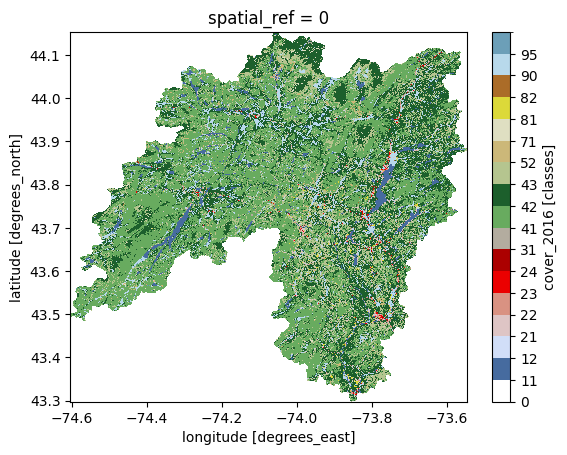

In [ ]:
nlcd = xr.open_dataset(cfg.file_paths.nlcd[0])
cmap, norm, levels = gh.cover_legends()
cover = nlcd.cover_2016
_ = cover.plot.imshow(cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})

In [7]:
nlcd_meta = gh.helpers.nlcd_helper()
pd.Series(nlcd_meta["classes"])

11     Open Water - All areas of open water, generall...
12     Perennial Ice/Snow - All areas characterized b...
21     Developed, Open Space - Includes areas with a ...
22     Developed, Low Intensity -Includes areas with ...
23     Developed, Medium Intensity - Includes areas w...
24     Developed, High Intensity - Includes highly de...
31     Barren Land (Rock/Sand/Clay) - Barren areas of...
41     Deciduous Forest - Areas dominated by trees ge...
42     Evergreen Forest - Areas dominated by trees ge...
43     Mixed Forest - Areas dominated by trees genera...
45     Shrub-Forest - Areas identified as currently s...
46     Herbaceous-Forest - Areas identified as curren...
51     Dwarf Scrub - Alaska only areas dominated by s...
52     Shrub/Scrub - Areas dominated by shrubs; less ...
71     Grassland/Herbaceous - Areas dominated by gram...
72     Sedge/Herbaceous - Alaska only areas dominated...
73     Lichens - Alaska only areas dominated by fruti...
74     Moss - Alaska only areas

In [8]:
urban_pct = cover.isin(range(21, 25)).sum() / cover.notnull().sum() * 100
f"{urban_pct.item():.2f} % of the area is urbanized"

'2.45 % of the area is urbanized'

In [9]:
data = xr.open_dataset(cfg.file_paths.forcing[0], decode_coords="all")
data = data.rename({"lat": "y", "lon": "x", "pr": "prcp", "tmmn": "tmin"})
data["tmin"] -= 273.15
data["tmin"].attrs["units"] = "°C"
# snow params from https://doi.org/10.5194/gmd-11-1077-2018
t_rain, t_snow = 2.5, 0.6
data = utils.separate_snow(data, t_rain, t_snow)
data = data.rio.clip([geoms.geometry.iloc[0]], crs=geoms.crs, all_touched=True)

In [10]:
snow_fraction = data.snow.resample(time="1YE").mean() / data.prcp.resample(time="1YE").mean()
snow_fraction = snow_fraction.mean().item() * 100
f"{snow_fraction:.1f}% of the precipitation is snow"

'44.0% of the precipitation is snow'

In [11]:
qobs_ds = xr.open_dataset(cfg.file_paths.streamflow[0])
qobs = qobs_ds.sel(station_id=f"USGS-{geoms.iloc[0].gage_id}").to_dataframe().discharge
qobs.index = pd.to_datetime(qobs.index.date)
qobs = qobs.loc[qobs.index.intersection(data.time.values)]

## Runoff Generation

In [12]:
prcp = utils.to_numpy(data["prcp"].mean(dim=["y", "x"]))
pet = utils.to_numpy(data["pet"].mean(dim=["y", "x"]))
tmin = utils.to_numpy(data["tmin"].mean(dim=["y", "x"]))
snow = utils.to_numpy(data["snow"].mean(dim=["y", "x"]))

In [13]:
runoff = np.zeros_like(prcp)
dv_soil = np.zeros_like(prcp)
src_soil = np.zeros_like(prcp)

dt = 60 * 60 * 24
lpt2cms = 1e-3 * area_sqm / dt
ms, sb, a = 0.5, 1000, 1

s_soil, s_snow = np.float64(0), np.float64(0)
t_range = t_rain - t_snow
cerr_max = np.float64(0)
for t in range(prcp.shape[0]):
    # Snowmelt (mm/day)
    if tmin[t] > t_rain:
        snm = (s_snow + snow[t]) * ms
    elif tmin[t] < t_snow:
        snm = np.float64(0)
    else:
        snm = (s_snow + snow[t]) * ms * (t_rain - tmin[t]) / t_range

    # Liquid water (mm/day)
    dv_soil[t] = snow[t] - snm
    s_snow = s_snow + dv_soil[t]
    liquid = prcp[t] - snow[t] + snm

    # Soil wetting (mm/day)
    m = s_soil * (2 * sb - a * s_soil) / (2 * sb * (sb - s_soil))
    wetting = np.minimum(
        (
            liquid
            + sb * np.sqrt(np.square(m + 1) - 2 * a * m)
            - np.sqrt(
                np.square(liquid + (m + 1) * sb) - 2 * a * m * np.square(sb) - 2 * a * sb * liquid
            )
        )
        / a,
        liquid,
    )

    # Evapotranspiration (mm/day)
    moisture = wetting + s_soil
    et = np.minimum(
        moisture * (pet[t] + sb - np.sqrt(np.square(pet[t] + sb) - 2 * a * sb * pet[t])) / (a * sb),
        moisture,
    )

    # Soil storage (mm/day)
    ds = wetting - et
    s_soil = s_soil + ds
    dv_soil[t] += ds

    # Total runoff: surface + subsurface (mm/day)
    runoff[t] = liquid - wetting
    src_soil[t] = prcp[t] - et
    cerr_max = np.maximum(cerr_max, np.abs(dv_soil[t] - 0.0 + runoff[t] - src_soil[t]))

runoff_cms = runoff * lpt2cms
results = pd.DataFrame({"runoff (cms)": runoff_cms}, index=data.time.values)
f"Water balance error: {cerr_max:.2e} mm/day"

'Water balance error: 1.42e-14 mm/day'

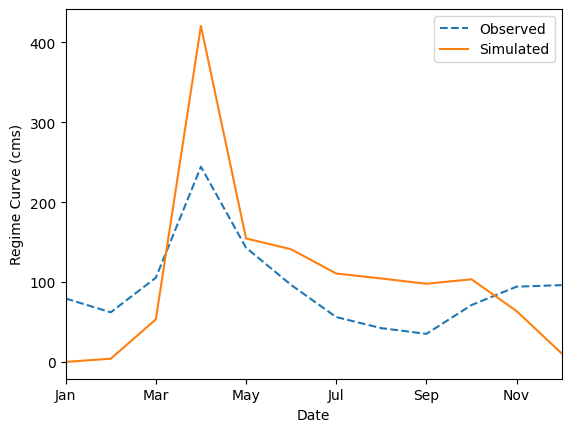

In [14]:
import hydrosignatures as hs
import matplotlib.pyplot as plt

rc_sim = hs.mean_monthly(results["runoff (cms)"], index_abbr=True, cms=True)
rc_obs = hs.mean_monthly(qobs, index_abbr=True, cms=True)

fig, ax = plt.subplots()
rc_obs.plot(ax=ax, ls="--", label="Observed")
rc_sim.plot(ax=ax, ls="-", label="Simulated")
ax.set_ylabel("Regime Curve (cms)")
ax.set_xlabel("Date")
ax.legend()
_ = ax.set_xmargin(0)

## Runoff Routing

We use Nash Cascading concept for routing the baseflow. For more info refer to [Ponce](https://ton.sdsu.edu/clr_method_of_choice.html).

In [15]:
gamma, kb, kd = 0.5, 0.07, 0.57

n_res_nash = 3
nt = runoff.shape[0]
q_sub = np.zeros_like(runoff)
q_sur = np.zeros_like(runoff)

s_sub_new = np.zeros(n_res_nash)
s_sur_new = np.float64(0)
outflow = np.zeros_like(runoff)
inflow = np.zeros_like(runoff)
cerr_max = np.float64(0)
for t in range(1, nt):
    # Subsurface runoff using Nash cascade and linear storage (mm/day)
    dv_sum = dv_soil[t] * lpt2cms
    q_sub_init = runoff[t] * (1.0 - gamma)
    for ii in range(n_res_nash):
        s_sub_old = np.float64(s_sub_new[ii])
        srg = s_sub_old + q_sub_init
        s_sub_new[ii] = (1.0 - kb) * srg
        q_sub_init = kb * srg
        dv_sum += (s_sub_new[ii] - s_sub_old) * lpt2cms

    # Surface runoff (mm/day); inflow should be converted to mm/day
    q_sur[t] = inflow[t] / lpt2cms + runoff[t] * gamma
    s_sur_old = np.float64(s_sur_new)
    srd = s_sur_old + q_sur[t]
    s_sur_new = (1.0 - kd) * srd
    q_sur[t] = kd * srd * lpt2cms
    dv_sum += (s_sur_new - s_sur_old) * lpt2cms

    # Convert to cms so all outputs are in the same unit (cms)
    q_sub[t] = q_sub_init * lpt2cms

    # Compute total outflow
    outflow[t] = q_sur[t] + q_sub[t]
    cerr_max = np.maximum(cerr_max, np.abs(dv_sum - inflow[t] + outflow[t] - src_soil[t] * lpt2cms))

results["outflow (cms)"] = outflow
results["q_sub (cms)"] = q_sub
results["q_sur (cms)"] = q_sur
results["inflow (cms)"] = inflow
f"Water balance error: {cerr_max:.2e} mm/day"

'Water balance error: 1.86e-12 mm/day'

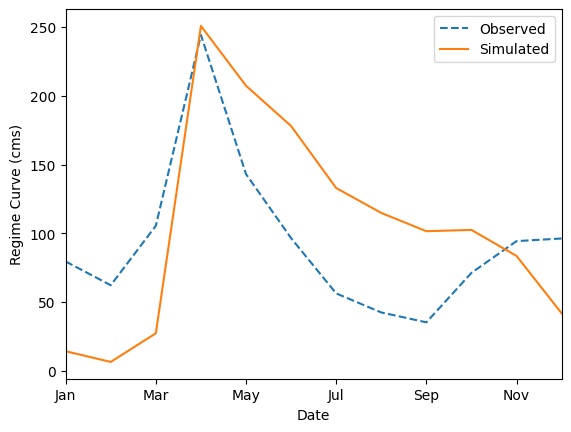

In [16]:
rc_sim = hs.mean_monthly(results["outflow (cms)"], index_abbr=True, cms=True)
rc_obs = hs.mean_monthly(qobs, index_abbr=True, cms=True)

fig, ax = plt.subplots()
rc_obs.plot(ax=ax, ls="--", label="Observed")
rc_sim.plot(ax=ax, ls="-", label="Simulated")
ax.set_ylabel("Regime Curve (cms)")
ax.set_xlabel("Date")
ax.legend()
_ = ax.set_xmargin(0)

## Model Calibration

In [17]:
from typing import TYPE_CHECKING, Any

from numba import config as nbconfig
from numba import njit

if TYPE_CHECKING:
    from numpy.typing import NDArray

    FloatArray = NDArray[np.float64]

nbconfig.THREADING_LAYER = "workqueue"


@njit(nogil=True, fastmath=True)
def runoff_generation(
    prcp: FloatArray,
    pet: FloatArray,
    tmin: FloatArray,
    snow: FloatArray,
    params: tuple[float, float, float],
) -> tuple[FloatArray, FloatArray, FloatArray]:
    """Runoff generation model."""
    runoff = np.zeros_like(prcp)
    dv_soil = np.zeros_like(prcp)
    src_soil = np.zeros_like(prcp)
    s_soil, s_snow = np.float64(0), np.float64(0)
    t_range = t_rain - t_snow
    cerr_max = np.float64(0)
    ms, sb, a = params
    for t in range(prcp.shape[0]):
        # Snowmelt (mm/day)
        if tmin[t] > t_rain:
            snm = (s_snow + snow[t]) * ms
        elif tmin[t] < t_snow:
            snm = np.float64(0)
        else:
            snm = (s_snow + snow[t]) * ms * (t_rain - tmin[t]) / t_range

        # Liquid water (mm/day)
        dv_soil[t] = snow[t] - snm
        s_snow = s_snow + dv_soil[t]
        liquid = prcp[t] - snow[t] + snm

        # Soil wetting (mm/day)
        m = s_soil * (2 * sb - a * s_soil) / (2 * sb * (sb - s_soil))
        wetting = np.minimum(
            (
                liquid
                + sb * np.sqrt(np.square(m + 1) - 2 * a * m)
                - np.sqrt(
                    np.square(liquid + (m + 1) * sb)
                    - 2 * a * m * np.square(sb)
                    - 2 * a * sb * liquid
                )
            )
            / a,
            liquid,
        )

        # Evapotranspiration (mm/day)
        moisture = wetting + s_soil
        et = np.minimum(
            moisture
            * (pet[t] + sb - np.sqrt(np.square(pet[t] + sb) - 2 * a * sb * pet[t]))
            / (a * sb),
            moisture,
        )

        # Soil storage (mm/day)
        ds = wetting - et
        s_soil = s_soil + ds
        dv_soil[t] += ds

        # Total runoff: surface + subsurface (mm/day)
        runoff[t] = liquid - wetting
        src_soil[t] = prcp[t] - et
        cerr_max = np.maximum(cerr_max, np.abs(dv_soil[t] - 0.0 + runoff[t] - src_soil[t]))
    if cerr_max > 1e-6:
        raise ValueError("Water balance error: ", round(cerr_max, 2))
    return runoff, dv_soil, src_soil


@njit(nogil=True, fastmath=True)
def runoff_routing(
    inflow: FloatArray,
    runoff: FloatArray,
    dv_soil: FloatArray,
    src_soil: FloatArray,
    params: tuple[float, float, float],
    lpt2cms: float,
) -> tuple[FloatArray, FloatArray, FloatArray]:
    """Runoff routing model."""
    gamma, kb, kd = params
    n_res_nash = 3
    nt = runoff.shape[0]
    q_sub = np.zeros_like(runoff)
    q_sur = np.zeros_like(runoff)
    s_sub_new = np.zeros(n_res_nash)
    s_sur_new = np.float64(0)

    outflow = np.zeros_like(runoff)
    cerr_max = np.float64(0)
    for t in range(1, nt):
        # Subsurface runoff using Nash cascade and linear storage (mm/day)
        dv_sum = dv_soil[t] * lpt2cms
        q_sub_init = runoff[t] * (1.0 - gamma)
        for ii in range(n_res_nash):
            s_sub_old = np.float64(s_sub_new[ii])
            srg = s_sub_old + q_sub_init
            s_sub_new[ii] = (1.0 - kb) * srg
            q_sub_init = kb * srg
            dv_sum += (s_sub_new[ii] - s_sub_old) * lpt2cms

        # Surface runoff (mm/day); inflow should be converted to mm/day
        q_sur[t] = inflow[t] / lpt2cms + runoff[t] * gamma
        s_sur_old = np.float64(s_sur_new)
        srd = s_sur_old + q_sur[t]
        s_sur_new = (1.0 - kd) * srd
        q_sur[t] = kd * srd * lpt2cms
        dv_sum += (s_sur_new - s_sur_old) * lpt2cms

        # Convert to cms so all outputs are in the same unit (cms)
        q_sub[t] = q_sub_init * lpt2cms

        # Compute total outflow
        outflow[t] = q_sur[t] + q_sub[t]
        cerr_max = np.maximum(
            cerr_max, np.abs(dv_sum - inflow[t] + outflow[t] - src_soil[t] * lpt2cms)
        )
    if cerr_max > 1e-6:
        raise ValueError("Water balance error: ", round(cerr_max, 2))
    return outflow, q_sur, q_sub


def nrcs_pdm(
    inflow: FloatArray,
    prcp: FloatArray,
    pet: FloatArray,
    tmin: FloatArray,
    snow: FloatArray,
    params: FloatArray,
    lpt2cms: float,
) -> tuple[FloatArray, FloatArray, FloatArray]:
    """Objective function to minimize."""
    ms, sb, a, gamma, kb, kd = params

    gen_params = (ms, sb, a)
    runoff, dv_soil, src_soil = runoff_generation(prcp, pet, tmin, snow, gen_params)

    rout_params = (gamma, kb, kd)
    outflow, q_sur, q_sub = runoff_routing(inflow, runoff, dv_soil, src_soil, rout_params, lpt2cms)
    return outflow, q_sur, q_sub

ms = 0.62, sb = 772.1, a = 1.67, gamma = 0.57, kb = 0.010, kd = 0.140


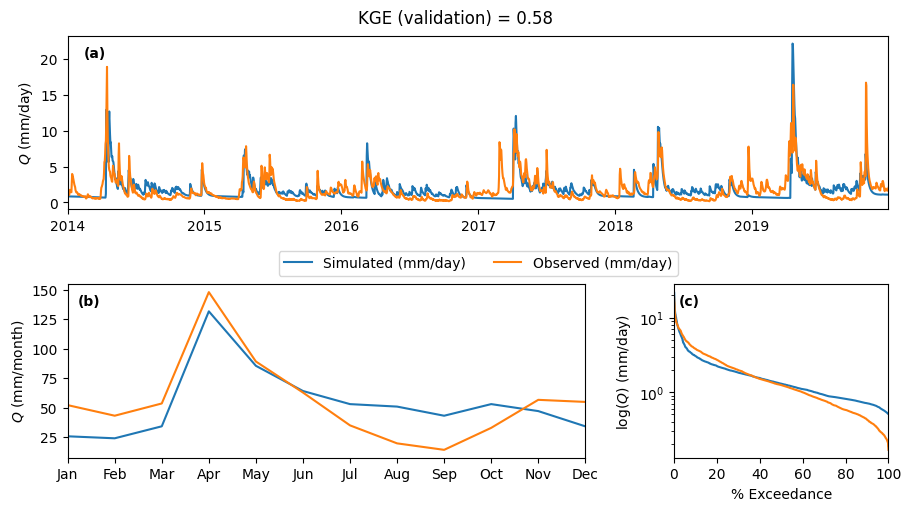

In [18]:
import sceua


def compute_kge(params: FloatArray, *args: Any) -> float:
    """Objective function to minimize."""
    prcp, pet, tmin, snow, qobs_arr, lpt2cms = args
    inflow = np.zeros_like(prcp)
    outflow, *_ = nrcs_pdm(inflow, prcp, pet, tmin, snow, params, lpt2cms)
    return -utils.compute_kge(outflow[365:], qobs_arr[365:])


cal_idx = int(len(prcp) * 0.7)

args = (
    prcp[:cal_idx],
    pet[:cal_idx],
    tmin[:cal_idx],
    snow[:cal_idx],
    utils.to_numpy(qobs)[:cal_idx],
    lpt2cms,
)
bounds = [(0.01, 0.99), (50.0, 2000.0), (0.01, 1.99), (0.01, 0.99), (0.01, 0.14), (0.14, 1)]
result = sceua.minimize(
    compute_kge,
    bounds=bounds,
    args=args,
    seed=42,
    n_complexes=3 * len(bounds),
    pca_freq=10,
    max_workers=8,
)

ms, sb_cal, a, gamma, kb, kd = result.x
print(
    f"ms = {ms:.2f}, sb = {sb_cal:.1f}, a = {a:.2f}, gamma = {gamma:.2f}, kb = {kb:.3f}, kd = {kd:.3f}"
)

inflow = np.zeros_like(prcp)
outflow, q_sur, q_sub = nrcs_pdm(inflow, prcp, pet, tmin, snow, result.x, lpt2cms)
q = pd.DataFrame(
    {
        "Simulated (mm/day)": outflow[cal_idx:],
        "Observed (mm/day)": utils.to_numpy(qobs)[cal_idx:],
        "Surface Runoff (mm/day)": q_sur[cal_idx:],
        "Subsurface Runoff (mm/day)": q_sub[cal_idx:],
    },
    index=qobs.index[cal_idx:],
)
q = q / lpt2cms
hs.plot.signatures(
    q[["Simulated (mm/day)", "Observed (mm/day)"]], title=f"KGE (validation) = {-result.fun:.2f}"
)

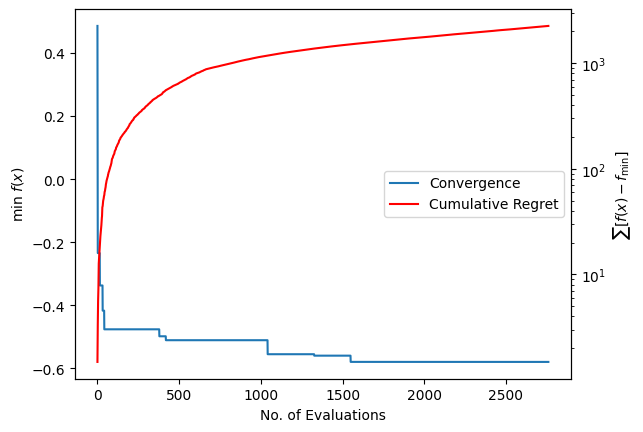

In [19]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("No. of Evaluations")
ax1.set_ylabel(r"$\min\ f(x)$")
ax1.plot(np.minimum.accumulate(result.funv))

ax2 = ax1.twinx()
ax2.set_yscale("log")
ax2.set_ylabel(r"$\sum \left[ f(x) - f_\mathrm{min} \right]$")
func_min = -1
ax2.plot(np.cumsum(result.funv - func_min), color="r")
_ = fig.legend(
    ["Convergence", "Cumulative Regret"],
    loc="right",
    bbox_to_anchor=(1, 0.5),
    bbox_transform=ax1.transAxes,
)

## Sensitivity Analysis

Number of samples: 14,336


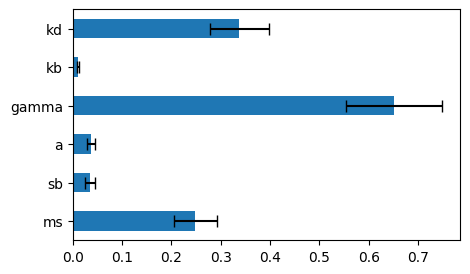

In [20]:
import warnings

from joblib import Parallel, delayed
from SALib import ProblemSpec

warnings.filterwarnings("ignore", category=FutureWarning, module="SALib")


sp = ProblemSpec(
    {
        "names": ["ms", "sb", "a", "gamma", "kb", "kd"],
        "num_vars": len(bounds),
        "bounds": bounds,
    }
)
seed = 42
samples = sp.sample_sobol(2**10)
print(f"Number of samples: {len(samples.samples):,}")
kges = Parallel(n_jobs=8, return_as="generator")(
    delayed(compute_kge)(params, prcp, pet, tmin, snow, utils.to_numpy(qobs), lpt2cms)
    for params in samples.samples
)
sp.set_results(np.asarray(list(kges)))
si = sp.analyze_sobol()
total, *_ = si.to_df()
_ = total.plot.barh(y="ST", xerr="ST_conf", capsize=4, legend=False, figsize=(5, 3))

In [21]:
layers = {
    "bd_0_5cm_mean": 5,
    "bd_5_15cm_mean": 10,
    "bd_15_30cm_mean": 15,
    "bd_30_60cm_mean": 30,
    "bd_60_100cm_mean": 40,
    "bd_100_200cm_mean": 100,
}
with xr.open_dataset(cfg.file_paths.soil[0]) as bd:
    sb_ap = sum((1 - bd[v] / 2.65) * lyr * 10 for v, lyr in layers.items()).mean().item()

ms = 0.70, sb = 916.1, a = 1.67, gamma = 0.60, kb = 0.017, kd = 0.140


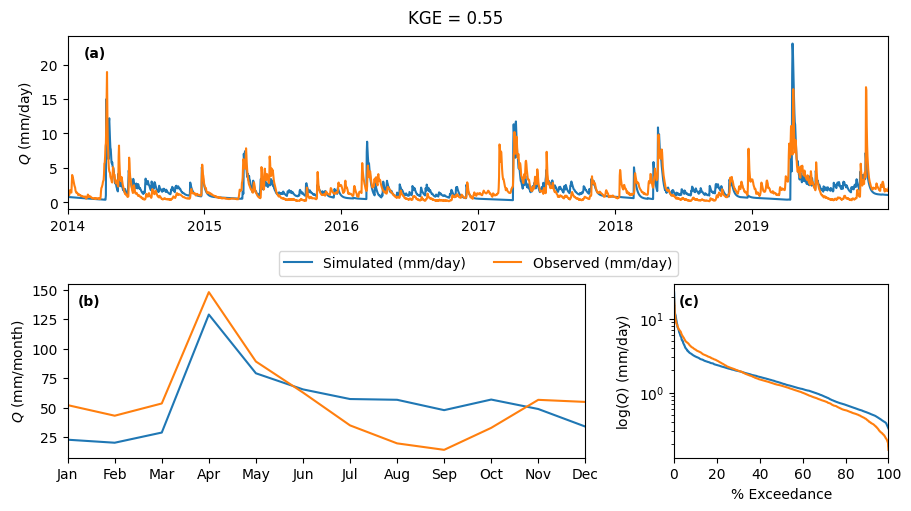

In [22]:
def compute_kge_no_sb(params: FloatArray, *args: Any) -> float:
    """Objective function to minimize."""
    prcp, pet, tmin, snow, sb, qobs_arr, lpt2cms = args
    params_full = np.array([params[0], sb, *params[1:]])
    inflow = np.zeros_like(prcp)
    outflow, *_ = nrcs_pdm(inflow, prcp, pet, tmin, snow, params_full, lpt2cms)
    return -utils.compute_kge(outflow[365:], qobs_arr[365:])


cal_idx = int(len(prcp) * 0.7)

args = (
    prcp[:cal_idx],
    pet[:cal_idx],
    tmin[:cal_idx],
    snow[:cal_idx],
    sb_ap,
    utils.to_numpy(qobs)[:cal_idx],
    lpt2cms,
)
bounds = [(0.01, 0.99), (0.01, 1.99), (0.01, 0.99), (0.01, 0.14), (0.14, 1)]
result = sceua.minimize(
    compute_kge_no_sb,
    bounds=bounds,
    args=args,
    seed=42,
    n_complexes=30 * len(bounds),
    pca_freq=10,
    max_workers=8,
)

params = np.array([result.x[0], sb_ap, *result.x[1:]])
print(
    f"ms = {params[0]:.2f}, sb = {sb_ap:.1f}, a = {params[2]:.2f}, gamma = {params[3]:.2f}, kb = {params[4]:.3f}, kd = {params[5]:.3f}"
)
inflow = np.zeros_like(prcp)
outflow, q_sur, q_sub = nrcs_pdm(inflow, prcp, pet, tmin, snow, params, lpt2cms)
q_no_sb = pd.DataFrame(
    {
        "Simulated (mm/day)": outflow[cal_idx:],
        "Observed (mm/day)": utils.to_numpy(qobs)[cal_idx:],
        "Surface Runoff (mm/day)": q_sur[cal_idx:],
        "Subsurface Runoff (mm/day)": q_sub[cal_idx:],
    },
    index=qobs.index[cal_idx:],
)
q_no_sb = q_no_sb / lpt2cms
hs.plot.signatures(
    q_no_sb[["Simulated (mm/day)", "Observed (mm/day)"]], title=f"KGE = {-result.fun:.2f}"
)

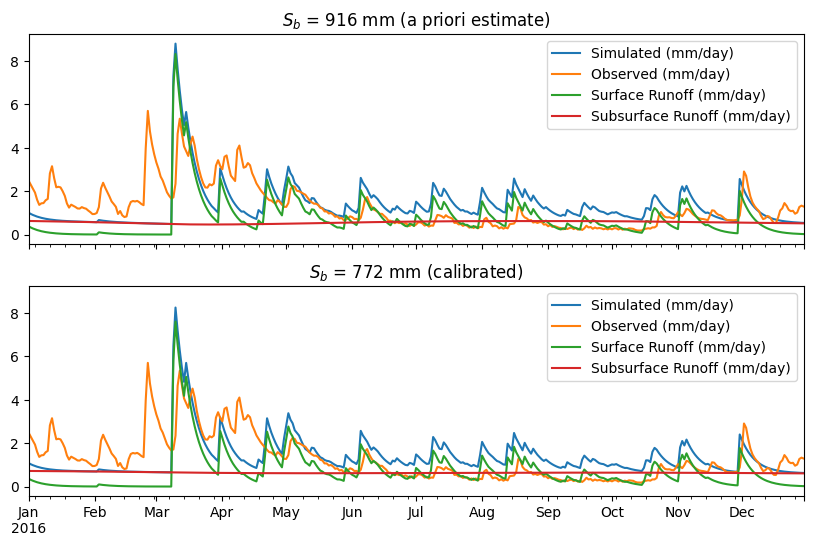

In [23]:
_, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
q_no_sb.loc[q_no_sb.index.year == 2016].plot(ax=axs[0])
axs[0].set_title(f"$S_b$ = {int(sb_ap)} mm (a priori estimate)")
q.loc[q.index.year == 2016].plot(ax=axs[1])
_ = axs[1].set_title(f"$S_b$ = {int(sb_cal)} mm (calibrated)")